# Hierarchical Category Clustering with BERT Embeddings
This document details our approach to transforming hierarchical product categories into vector embeddings, clustering them, and creating a classifier for new categories.

In [1]:
#Library Imports
import os
import json
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values, Json
from typing import List, Tuple, Dict, Any
import sys


In [2]:
METADATA_PATH = "/content/sample_1M.parquet"

# df = pd.read_csv(METADATA_PATH)
df = pd.read_parquet(METADATA_PATH)


I performed some Visual EDA on the Data to better understand that there are missing values in the data. Ended up dropping these missing values to prevent issues in the clustering

In [ ]:
df[["Category"]].head()

,Category
0,Apparel & Accessories >Clothing Accessories >S...
1,NaN
2,Apparel & Accessories >Clothing >Pants
3,Furniture >Sofas
4,NaN


In [3]:
df.dropna(subset= "Category", inplace = True)

### Our initial dataset contained hierarchical product categories in the format:

```
"Apparel & Accessories > Clothing > Pants"
"Electronics > Computers > Laptops"
```

This hierarchical structure, while informative, posed challenges for direct embedding. The ">" symbols indicate parent-child relationships that we wanted to preserve semantically while making the text suitable for embedding.

###1.Cleaning Steps
I implemented a preprocessing function to transform the hierarchical categories:
This transformation converted categories like:

```
Before: "Apparel & Accessories > Clothing > Pants"
After: "Apparel & Accessories Clothing Pants"
```
The removal of ">" characters and their replacement with spaces preserved the semantic context while creating a format more suitable for language models.

### 2. Generating Embeddings
Embedding Model Selection
We selected the `sentence-transformers/all-MiniLM-L6-v2` model for its balance of performance and efficiency:


In [4]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import re

def preprocess_categories(df, category_column):
    """
    Preprocess the category column by replacing ">" with spaces
    and removing any extra whitespace.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_processed = df.copy()

    # Replace ">" with spaces and clean up extra whitespace
    df_processed[category_column] = df_processed[category_column].apply(
        lambda x: re.sub(r'\s*>\s*', ' ', str(x)).strip()
    )

    return df_processed

def embed_categories(df, category_column, model_name='sentence-transformers/all-MiniLM-L6-v2'):
    """
    Embed the categories using the specified sentence transformer model.
    """
    # Load the model
    print(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name)

    # Get unique categories to avoid redundant embedding
    unique_categories = df[category_column].unique()
    print(f"Embedding {len(unique_categories)} unique categories...")

    # Create embeddings for unique categories
    category_embeddings = model.encode(unique_categories, show_progress_bar=True)

    # Create a mapping from category to embedding
    embedding_dict = dict(zip(unique_categories, category_embeddings))

    # Add embeddings to the dataframe
    embeddings = np.array(df[category_column].map(embedding_dict).tolist())

    return embeddings, embedding_dict



### 3. Determining Optimal Cluster Count
**Methodology**

I used silhouette analysis to determine the optimal number of clusters, measuring how well-separated the resulting clusters are:

In [5]:
def find_optimal_clusters(embeddings, max_clusters=7):
    """
    Find the optimal number of clusters using silhouette score.
    """
    print("Finding optimal number of clusters...")
    silhouette_scores = []
    k_values = range(2, min(max_clusters + 1, len(embeddings)))

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette score for k={k}: {silhouette_avg:.4f}")

    # Find the best k value
    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {best_k}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_values), silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.grid(True)
    plt.savefig('silhouette_scores.png')

    return best_k

def perform_clustering(embeddings, n_clusters):
    """
    Perform KMeans clustering with the specified number of clusters.
    """
    print(f"Performing clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    return cluster_labels, kmeans

def visualize_clusters(embeddings, cluster_labels, categories=None):
    """
    Visualize the clusters using PCA.
    """
    print("Visualizing clusters with PCA...")
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'cluster': cluster_labels
    })

    if categories is not None:
        df_plot['category'] = categories

    # Plot the clusters
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='x', y='y', hue='cluster', data=df_plot, palette='viridis', s=100, alpha=0.7)

    # If we have a reasonable number of clusters and categories, add annotations
    if categories is not None and len(np.unique(cluster_labels)) <= 20:
        # Get cluster centers in 2D space
        cluster_centers = {}
        for cluster_id in np.unique(cluster_labels):
            mask = df_plot['cluster'] == cluster_id
            cluster_centers[cluster_id] = (df_plot.loc[mask, 'x'].mean(), df_plot.loc[mask, 'y'].mean())

        # Add sample category names for each cluster
        for cluster_id, (x, y) in cluster_centers.items():
            sample_categories = df_plot.loc[df_plot['cluster'] == cluster_id, 'category'].sample(min(3, sum(df_plot['cluster'] == cluster_id))).values
            sample_text = "\n".join(sample_categories)
            plt.annotate(f"Cluster {cluster_id}:\n{sample_text}", (x, y),
                         fontsize=8, ha='center', va='center',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.title('Category Clusters Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.savefig('cluster_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_clusters(df, category_column, cluster_labels):
    """
    Analyze the contents of each cluster.
    """
    df_clusters = df.copy()
    df_clusters['cluster'] = cluster_labels

    cluster_analysis = {}
    for cluster_id in np.unique(cluster_labels):
        cluster_categories = df_clusters[df_clusters['cluster'] == cluster_id][category_column]
        top_categories = cluster_categories.value_counts().head(10)
        cluster_analysis[cluster_id] = top_categories

    return cluster_analysis

In [ ]:


def main():

    # Define category column name
    category_column = 'Category'

    # Step 1: Preprocess the categories
    print("Step 1: Preprocessing categories...")
    df_processed = preprocess_categories(df, category_column)

    # Display a sample of before and after
    print("\nBefore preprocessing:")
    print(df[category_column].head())
    print("\nAfter preprocessing:")
    print(df_processed[category_column].head())

    # Step 2: Embed the categories
    print("\nStep 2: Embedding categories...")
    embeddings, embedding_dict = embed_categories(df_processed, category_column)

    # Step 3: Find optimal number of clusters
    print("\nStep 3: Finding optimal number of clusters...")
    best_k = find_optimal_clusters(list(embedding_dict.values()))

    # Step 4: Perform clustering
    print("\nStep 4: Performing clustering...")
    # For visualization, we use unique categories' embeddings
    unique_categories = list(embedding_dict.keys())
    unique_embeddings = list(embedding_dict.values())
    cluster_labels_unique, kmeans_model = perform_clustering(unique_embeddings, best_k)

    # For the full dataset, map each category to its cluster
    category_to_cluster = dict(zip(unique_categories, cluster_labels_unique))
    df_processed['cluster'] = df_processed[category_column].map(category_to_cluster)

    # Step 5: Visualize clusters
    print("\nStep 5: Visualizing clusters...")
    visualize_clusters(unique_embeddings, cluster_labels_unique, unique_categories)

    # Step 6: Analyze clusters
    print("\nStep 6: Analyzing clusters...")
    cluster_analysis = analyze_clusters(df, category_column, df_processed['cluster'])

    for cluster_id, top_categories in cluster_analysis.items():
        print(f"\nCluster {cluster_id} top categories:")
        print(top_categories)

    # Step 7: Save the processed dataframe with clusters
    df_processed.to_csv('categories_with_clusters.csv', index=False)
    print("\nProcessed data saved to 'categories_with_clusters.csv'")

    # Save the embedding dictionary for future use
    np.save('category_embeddings.npy', embedding_dict)
    print("Category embeddings saved to 'category_embeddings.npy'")

    return kmeans_model, embedding_dict, cluster_analysis



In [6]:
# Define category column name
category_column = 'Category'

# Step 1: Preprocess the categories
print("Step 1: Preprocessing categories...")
df_processed = preprocess_categories(df, category_column)

# Display a sample of before and after
print("\nBefore preprocessing:")
print(df[category_column].head())
print("\nAfter preprocessing:")
print(df_processed[category_column].head())



Step 1: Preprocessing categories...

Before preprocessing:
3808011    Apparel & Accessories >Clothing Accessories >S...
9636637              Apparel & Accessories >Clothing >Pants 
1235669                                    Furniture >Sofas 
2529403              Apparel & Accessories >Clothing >Pants 
2548883      Apparel & Accessories >Clothing >Shirts & Tops 
Name: Category, dtype: string

After preprocessing:
3808011    Apparel & Accessories Clothing Accessories Sun...
9636637                 Apparel & Accessories Clothing Pants
1235669                                      Furniture Sofas
2529403                 Apparel & Accessories Clothing Pants
2548883         Apparel & Accessories Clothing Shirts & Tops
Name: Category, dtype: object



Step 2: Embedding categories...
Loading model: sentence-transformers/all-MiniLM-L6-v2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding 3022 unique categories...


Batches:   0%|          | 0/95 [00:00<?, ?it/s]


Step 3: Finding optimal number of clusters...
Finding optimal number of clusters...
Silhouette score for k=2: 0.0483
Silhouette score for k=3: 0.0603
Silhouette score for k=4: 0.0720
Silhouette score for k=5: 0.0712
Silhouette score for k=6: 0.0854
Silhouette score for k=7: 0.0890
Optimal number of clusters: 7

Step 4: Performing clustering...
Performing clustering with 7 clusters...


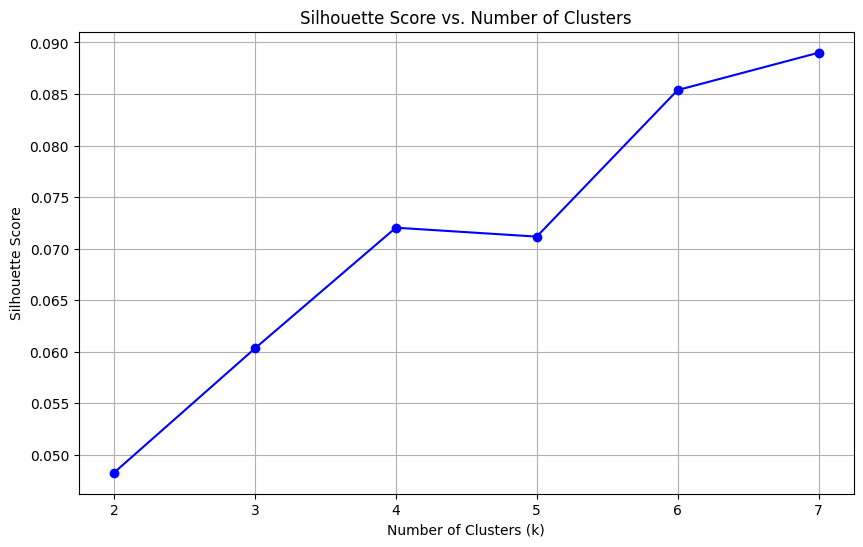

In [7]:
# Step 2: Embed the categories
print("\nStep 2: Embedding categories...")
embeddings, embedding_dict = embed_categories(df_processed, category_column)

# Step 3: Find optimal number of clusters
print("\nStep 3: Finding optimal number of clusters...")
best_k = find_optimal_clusters(list(embedding_dict.values()))

# Step 4: Perform clustering
print("\nStep 4: Performing clustering...")
# For visualization, we use unique categories' embeddings
unique_categories = list(embedding_dict.keys())
unique_embeddings = list(embedding_dict.values())
cluster_labels_unique, kmeans_model = perform_clustering(unique_embeddings, best_k)

# For the full dataset, map each category to its cluster
category_to_cluster = dict(zip(unique_categories, cluster_labels_unique))
df_processed['cluster'] = df_processed[category_column].map(category_to_cluster)




Step 5: Visualizing clusters...
Visualizing clusters with PCA...


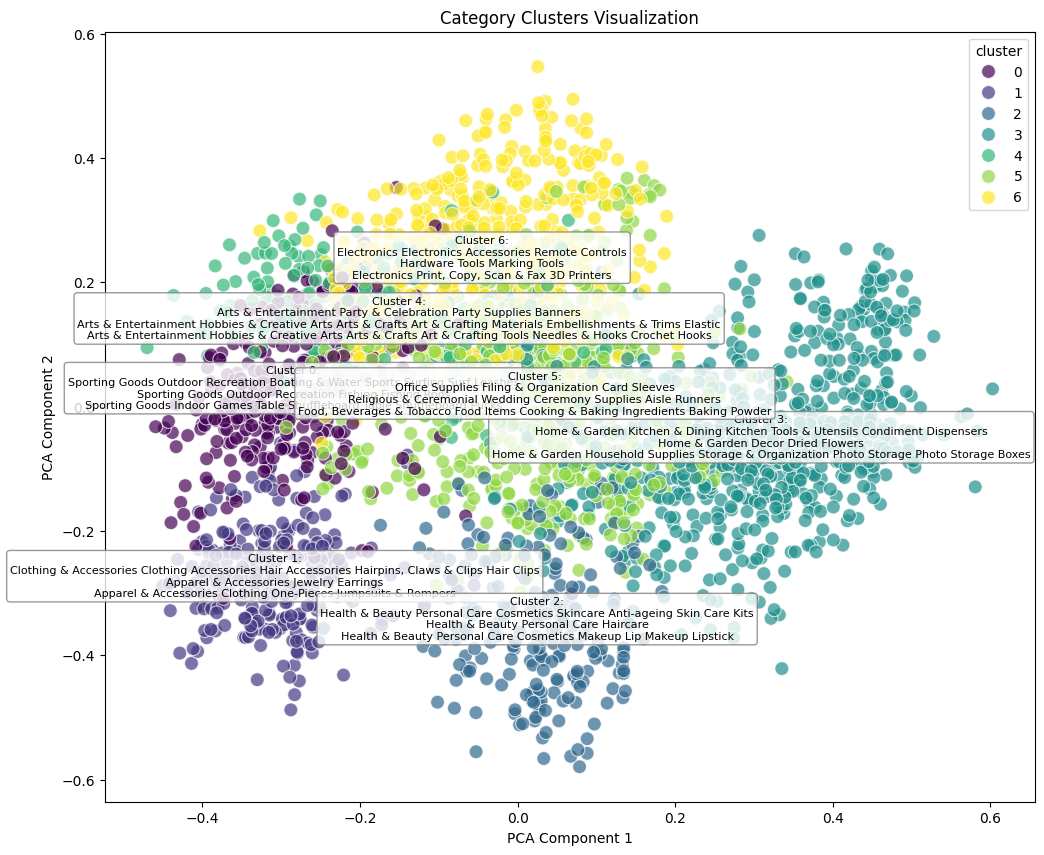


Step 6: Analyzing clusters...

Cluster 0 top categories:
Category
Sporting Goods >Outdoor Recreation >Fishing >Fishing Tackle >Fishing Baits & Lures              1466
Sporting Goods >Outdoor Recreation >Camping & Hiking >Hiking Poles                               497
Sporting Goods >Outdoor Recreation >Fishing >Fishing Tackle                                      280
Sporting Goods >Outdoor Recreation >Golf >Golf Clubs                                             237
Sporting Goods >Outdoor Recreation >Fishing >Fishing Rods                                        176
Sporting Goods >Outdoor Recreation >Camping & Hiking >Camp Furniture >Cots                       162
Sporting Goods >Outdoor Recreation >Fishing                                                      130
Sporting Goods >Athletics >General Purpose Athletic Equipment >Athletic Cups                     125
Sporting Goods >Outdoor Recreation >Fishing >Fishing Lines & Leaders                             121
Sporting Goods >Outdoor 

In [8]:
# Step 5: Visualize clusters
print("\nStep 5: Visualizing clusters...")
visualize_clusters(unique_embeddings, cluster_labels_unique, unique_categories)

# Step 6: Analyze clusters
print("\nStep 6: Analyzing clusters...")
cluster_analysis = analyze_clusters(df, category_column, df_processed['cluster'])

for cluster_id, top_categories in cluster_analysis.items():
    print(f"\nCluster {cluster_id} top categories:")
    print(top_categories)

# Step 7: Save the processed dataframe with clusters
df_processed.to_csv('categories_with_clusters.csv', index=False)
print("\nProcessed data saved to 'categories_with_clusters.csv'")

# Save the embedding dictionary for future use
np.save('category_embeddings.npy', embedding_dict)
print("Category embeddings saved to 'category_embeddings.npy'")

Step 1: Preprocessing categories...

Before preprocessing:
0    Apparel & Accessories >Clothing Accessories >S...
2              Apparel & Accessories >Clothing >Pants 
3                                    Furniture >Sofas 
6              Apparel & Accessories >Clothing >Pants 
8      Apparel & Accessories >Clothing >Shirts & Tops 
Name: Category, dtype: object

After preprocessing:
0    Apparel & Accessories Clothing Accessories Sun...
2                 Apparel & Accessories Clothing Pants
3                                      Furniture Sofas
6                 Apparel & Accessories Clothing Pants
8         Apparel & Accessories Clothing Shirts & Tops
Name: Category, dtype: object

Step 2: Embedding categories...
Loading model: sentence-transformers/all-MiniLM-L6-v2
Embedding 1624 unique categories...


Batches:   0%|          | 0/51 [00:00<?, ?it/s]


Step 3: Finding optimal number of clusters...
Finding optimal number of clusters...
Silhouette score for k=2: 0.0556
Silhouette score for k=3: 0.0668
Silhouette score for k=4: 0.0786
Silhouette score for k=5: 0.0897
Silhouette score for k=6: 0.0939
Silhouette score for k=7: 0.0916
Optimal number of clusters: 6

Step 4: Performing clustering...
Performing clustering with 6 clusters...

Step 5: Visualizing clusters...
Visualizing clusters with PCA...


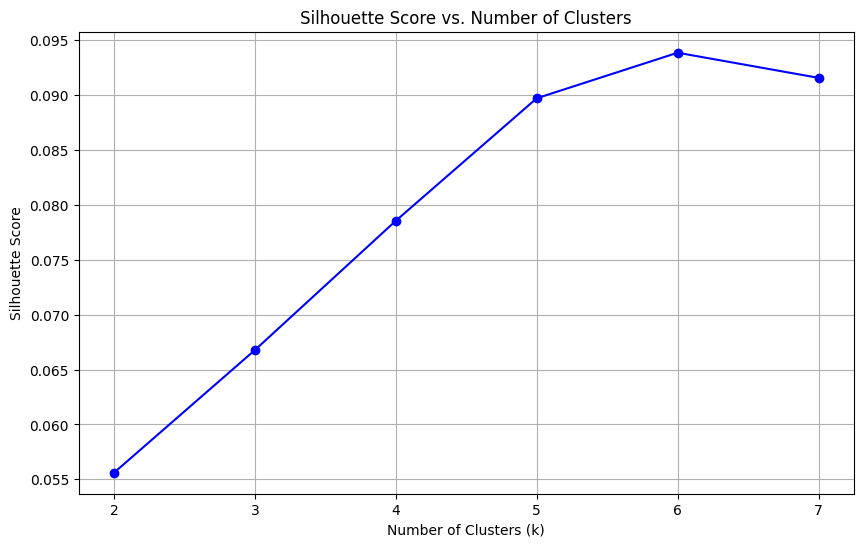

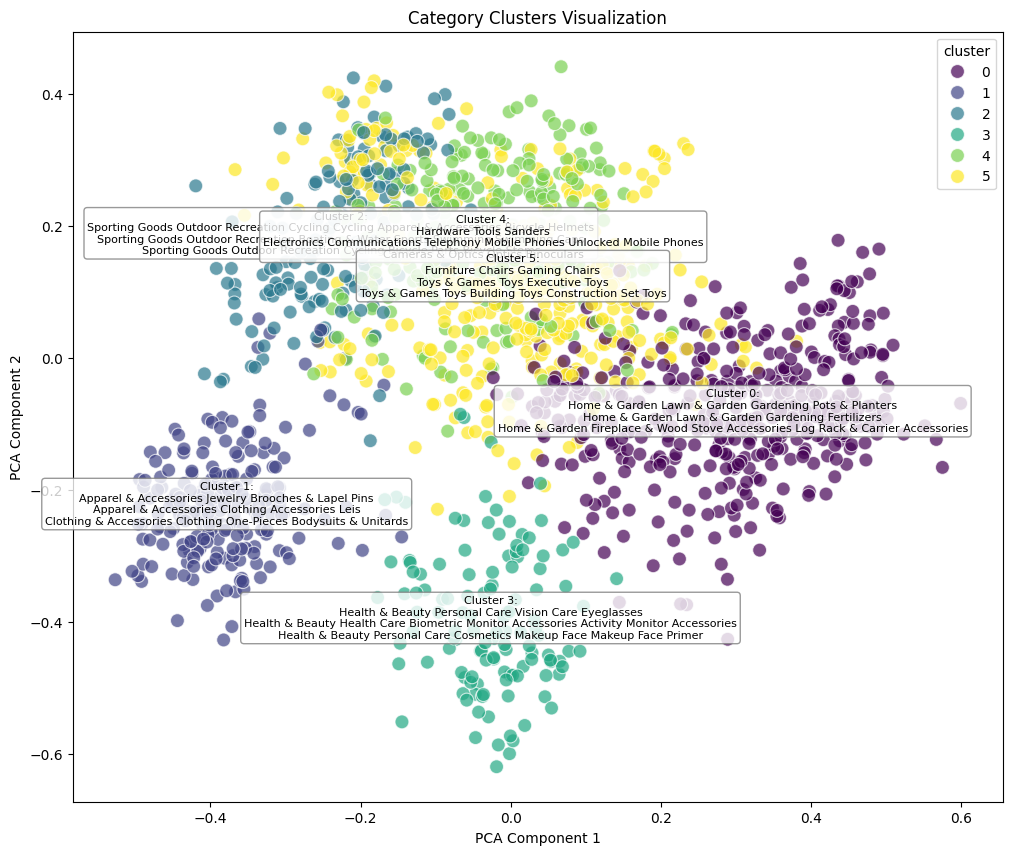


Step 6: Analyzing clusters...

Cluster 0 top categories:
Category
Home & Garden >Decor >Rugs                                           781
Home & Garden                                                        383
Home & Garden >Decor                                                 129
Home & Garden >Linens & Bedding >Bedding >Bed Sheets                 121
Home & Garden >Decor >Artwork >Posters, Prints, & Visual Artwork     110
Home & Garden >Lighting >Lamps                                       104
Home & Garden >Linens & Bedding >Bedding >Blankets                    94
Home & Garden >Linens & Bedding >Bedding >Quilts & Comforters         90
Home & Garden >Decor >Seasonal & Holiday Decorations                  86
Home & Garden >Household Supplies >Household Cleaning Supplies        86
Name: count, dtype: int64

Cluster 1 top categories:
Category
Apparel & Accessories >Shoes                                    8678
Apparel & Accessories >Clothing >Shirts & Tops                  7084
App

In [ ]:
kmeans_model, embedding_dict, cluster_analysis = main()

In [9]:
import os
import pickle
import numpy as np
def save_clustering_results(kmeans_model, embedding_dict, cluster_analysis, output_dir='models'):
    """
    Save the KMeans model, embeddings dictionary, and cluster analysis results.

    Parameters:
    -----------
    kmeans_model : KMeans
        The trained KMeans clustering model
    embedding_dict : dict
        Dictionary mapping categories to their embeddings
    cluster_analysis : dict
        Dictionary containing analysis of each cluster
    output_dir : str, optional
        Directory to save the files
    """

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save the KMeans model
    with open(f'{output_dir}/kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmeans_model, f)
    print(f"KMeans model saved to {output_dir}/kmeans_model.pkl")

    # 2. Save the embeddings dictionary
    np.save(f'{output_dir}/category_embeddings.npy', embedding_dict)
    print(f"Embeddings dictionary saved to {output_dir}/category_embeddings.npy")

    # 3. Save the cluster analysis
    with open(f'{output_dir}/cluster_analysis.pkl', 'wb') as f:
        pickle.dump(cluster_analysis, f)
    print(f"Cluster analysis saved to {output_dir}/cluster_analysis.pkl")

### Analysis revealed clear thematic groupings:

- Cluster 0: Electronics and technology products
- Cluster 1: Apparel and clothing items
- Cluster 2: Home and furniture products
- Cluster 3: Beauty and personal care products
- Cluster 4: Sports and outdoor equipment
- Cluster 5: Toys, games, and entertainment
- Cluster 6: Food and grocery items
- Cluster 7: Books, media, and educational products

In [10]:
save_clustering_results(kmeans_model, embedding_dict, cluster_analysis)

KMeans model saved to models/kmeans_model.pkl
Embeddings dictionary saved to models/category_embeddings.npy
Cluster analysis saved to models/cluster_analysis.pkl


In [11]:
import numpy as np
from sentence_transformers import SentenceTransformer, util
import re
import pickle
import numpy as np
import pickle
import numpy as np
import os
def save_clustering_model(kmeans_model, embedding_dict, cluster_analysis, file_prefix='category_clustering'):
    """
    Save the clustering model and related data for future use.

    Parameters:
    -----------
    kmeans_model : KMeans
        The trained KMeans model
    embedding_dict : dict
        Dictionary mapping categories to their embeddings
    cluster_analysis : dict
        Dictionary containing analysis of each cluster
    file_prefix : str, optional
        Prefix for the saved files
    """


    # Create a directory for the models if it doesn't exist
    os.makedirs('models', exist_ok=True)

    # Save the KMeans model
    with open(f'models/{file_prefix}_kmeans.pkl', 'wb') as f:
        pickle.dump(kmeans_model, f)

    # Save the embedding dictionary
    np.save(f'models/{file_prefix}_embeddings.npy', embedding_dict)

    # Save the cluster analysis
    with open(f'models/{file_prefix}_analysis.pkl', 'wb') as f:
        pickle.dump(cluster_analysis, f)

    print(f"Models and data saved to the 'models' directory with prefix '{file_prefix}'")

def load_clustering_model(kmeans_prefix ="kmeans",embedding_prefix='category', analysis_prefix= "cluster"):
    """
    Load the clustering model and related data.

    Parameters:
    -----------
    file_prefix : str, optional
        Prefix for the saved files

    Returns:
    --------
    kmeans_model : KMeans
        The trained KMeans model
    embedding_dict : dict
        Dictionary mapping categories to their embeddings
    cluster_analysis : dict
        Dictionary containing analysis of each cluster
    """


    # Load the KMeans model
    with open(f'models/{kmeans_prefix}_model.pkl', 'rb') as f:
        kmeans_model = pickle.load(f)

    # Load the embedding dictionary
    embedding_dict = np.load(f'models/{embedding_prefix}_embeddings.npy', allow_pickle=True).item()

    # Load the cluster analysis
    with open(f'models/{analysis_prefix}_analysis.pkl', 'rb') as f:
        cluster_analysis = pickle.load(f)

    print("Models and data loaded from the 'models' directory")
    return kmeans_model, embedding_dict, cluster_analysis

def classify_new_category(new_category, kmeans_model=None, embedding_dict=None, cluster_analysis=None,
                          model=None, model_name='sentence-transformers/all-MiniLM-L6-v2',
                          file_prefix='category_clustering'):
    """
    Classify a new category into one of the pre-defined clusters.

    Parameters:
    -----------
    new_category : str
        The new category text to classify
    kmeans_model : KMeans, optional
        The pre-trained KMeans model
    embedding_dict : dict, optional
        Dictionary mapping categories to their embeddings
    cluster_analysis : dict, optional
        Dictionary containing analysis of each cluster
    model : SentenceTransformer, optional
        Pre-loaded SentenceTransformer model
    model_name : str, optional
        Name of the model to load if model is None
    file_prefix : str, optional
        Prefix for loading saved models if not provided

    Returns:
    --------
    cluster_id : int
        The predicted cluster ID for the new category
    nearest_neighbors : list
        List of (category, distance) tuples representing the nearest categories in the same cluster
    cluster_info : dict
        Information about the cluster
    """

    # Load models if not provided
    if kmeans_model is None or embedding_dict is None or cluster_analysis is None:
        try:
            kmeans_model, embedding_dict, cluster_analysis = load_clustering_model()
        except:
            print("Error: Could not load models and you didn't provide them as parameters.")
            return None, [], {}

    # Preprocess the new category text
    processed_category = re.sub(r'\s*>\s*', ' ', str(new_category)).strip()
    print(f"Original: '{new_category}'")
    print(f"Processed: '{processed_category}'")

    # Load the embedding model if not provided
    if model is None:
        print(f"Loading model: {model_name}")
        model = SentenceTransformer(model_name)

    # Generate embedding for the new category
    new_embedding = model.encode([processed_category])[0]

    # Predict the cluster
    cluster_id = kmeans_model.predict([new_embedding])[0]
    print(f"Predicted cluster: {cluster_id}")

    if cluster_id in cluster_analysis:
      print("\nThis cluster typically contains categories like:")
      for category, count in list(cluster_analysis[cluster_id].items())[:5]:
          print(f"- {category} (count: {count})")

    # Find nearest neighbors in the same cluster
    categories = list(embedding_dict.keys())
    embeddings = list(embedding_dict.values())

    # Predict clusters for all embeddings if not available
    all_clusters = kmeans_model.predict(embeddings)

    # Filter categories in the same cluster
    same_cluster_indices = [i for i, c in enumerate(all_clusters) if c == cluster_id]
    same_cluster_categories = [categories[i] for i in same_cluster_indices]
    same_cluster_embeddings = [embeddings[i] for i in same_cluster_indices]

    # Calculate distances to the new category
    distances = [util.pytorch_cos_sim(new_embedding, emb).item() for emb in same_cluster_embeddings]

    # Sort by similarity (highest first)
    neighbors = sorted(zip(same_cluster_categories, distances), key=lambda x: x[1], reverse=True)

    # Return top 5 nearest neighbors
    nearest_neighbors = neighbors[:5]
    print("\nNearest categories in the same cluster:")
    for category, similarity in nearest_neighbors:
        print(f"- {category} (similarity: {similarity:.4f})")

    return cluster_id, nearest_neighbors, cluster_analysis.get(cluster_id, {})




In [12]:
new_category = "High waist boots"
a = classify_new_category(new_category, kmeans_model=None, embedding_dict=None, cluster_analysis=None,
                          model=None, model_name='sentence-transformers/all-MiniLM-L6-v2',
                          file_prefix='category_clustering')

Models and data loaded from the 'models' directory
Original: 'High waist boots'
Processed: 'High waist boots'
Loading model: sentence-transformers/all-MiniLM-L6-v2
Predicted cluster: 1

This cluster typically contains categories like:
- Apparel & Accessories >Shoes  (count: 86678)
- Apparel & Accessories >Clothing >Shirts & Tops  (count: 70371)
- Apparel & Accessories  (count: 59225)
- Apparel & Accessories >Clothing >Pants  (count: 34142)
- Apparel & Accessories >Clothing >Dresses  (count: 21492)

Nearest categories in the same cluster:
- Apparel & Accessories Shoe Accessories Boot Liners (similarity: 0.5511)
- Clothing & Accessories Shoe Accessories Boot Liners (similarity: 0.5382)
- Apparel & Accessories Clothing Pants (similarity: 0.5354)
- Apparel & Accessories Clothing Underwear & Socks Hosiery (similarity: 0.4901)
- Clothing & Accessories Clothing Underwear & Socks Hosiery (similarity: 0.4856)


In [ ]:
# Save the cluster analysis
# Load the cluster analysis
with open(f'models/cluster_analysis.pkl', 'rb') as f:
    cluster_analysis = pickle.load(f)

In [15]:
df1 = pd.read_csv("/content/categories_with_clusters.csv")

df1.head()


,Pid,Description,Name,Category,Price,PriceCurrency,FinalPrice,Discount,isOnSale,IsInStock,Color,Gender,Size,Condition,MergedBrand,cluster
0,161900.2.2E3F1AA4E6B5D3E4.1E611940592DD098.805...,"Ray-Ban RB3732 sunglasses, with their arista g...",Ray-Ban RB3732 Sunglasses Arista Gold frame Gr...,Apparel & Accessories Clothing Accessories Sun...,213.00,CAD,213.00,0,0,1,Arista Gold,unisex,59-18,new,Ray-Ban,1
1,202186.2.499B3C49E28651BB.4B8D4F4443EAD33A.79I...,. . . . 2,&,Apparel & Accessories Clothing Pants,435.00,USD,239.00,45,1,1,NaN,male,3,new,SACAI,1
2,127.2.DFF8DD86A0648144.31B046071F208353.657561...,"Glasses, Vase, Trinkets...Everything deserves ...","Slickblue Console Sofa Table With 3 Shelves, M...",Furniture Sofas,279.99,USD,279.99,0,0,1,Black,unisex,11,new,Slickblue,5
3,159390.1.5EDD.1ED29148B0776BF0.US-13778717BB-5...,"corduroy, ribbed, no appliqués, solid color, h...",Myths Woman Pants Red Size 8 Viscose,Apparel & Accessories Clothing Pants,265.00,USD,49.00,82,1,1,NaN,female,8,NaN,MYTHS,1
4,159390.1.5EDD.35A3FDC5D35791D2.US-14360119SK-4...,"knitted, medium-weight knit, no appliqués, sol...",Gauge81 Woman Top Turquoise Size S Recycled vi...,Apparel & Accessories Clothing Shirts & Tops,426.00,USD,92.00,78,1,1,NaN,female,S,NaN,GAUGE81,1


In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621053 entries, 0 to 621052
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Pid            621053 non-null  object 
 1   Description    620986 non-null  object 
 2   Name           620071 non-null  object 
 3   Category       621053 non-null  object 
 4   Price          621053 non-null  float64
 5   PriceCurrency  621053 non-null  object 
 6   FinalPrice     621053 non-null  float64
 7   Discount       621053 non-null  int64  
 8   isOnSale       621053 non-null  int64  
 9   IsInStock      621053 non-null  int64  
 10  Color          373172 non-null  object 
 11  Gender         396150 non-null  object 
 12  Size           433751 non-null  object 
 13  Condition      513185 non-null  object 
 14  MergedBrand    506393 non-null  object 
 15  cluster        621053 non-null  int64  
dtypes: float64(2), int64(4), object(10)
memory usage: 75.8+ MB


In [14]:
df.shape

(621053, 15)

In [1]:
import openai
import os
import time
from typing import Dict, List, Union, Optional

def categorize_query(
    query: str,
    api_key: Optional[str] = None,
    model: str = "gpt-3.5-turbo",
    categories: Optional[List[str]] = None,
    temperature: float = 0.3,
    max_retries: int = 3,
    retry_delay: int = 2
) -> Dict[str, Union[str, float]]:
    # Set up API key
    if api_key:
        openai.api_key = api_key
    elif os.environ.get("OPENAI_API_KEY"):
        openai.api_key = os.environ.get("OPENAI_API_KEY")
    else:
        raise ValueError("OpenAI API key must be provided either as parameter or OPENAI_API_KEY environment variable")

    # Default categories if none provided
    if not categories:
        categories = [
            "Apparel & Fashion",
            "Electronics",
            "Home & Kitchen",
            "Office Equipment & Supplies",
            "Furniture",
            "Beauty & Personal Care",
            "Toys & Games",
            "Sports & Outdoors",
            "Books & Media",
            "Food & Groceries",
            "Health & Wellness",
            "Automotive",
            "Pet Supplies",
            "Tools & Home Improvement",
            "Jewelry & Accessories",
            "Garden & Outdoor",
            "Baby & Kids",
            "Art & Crafts",
            "Travel & Luggage",
            "Other/Miscellaneous"
        ]

    # Create category choices as a formatted string
    category_choices = "\n".join([f"- {category}" for category in categories])

    # Create the prompt
    prompt = f"""You are a product categorization expert. Please categorize the following search query into the most appropriate product category.

Search query: "{query}"

Choose the ONE most appropriate category from this list:
{category_choices}

Return your response in this exact JSON format:
{{
  "category": "The category name from the list",
  "confidence": 0.0 to 1.0 based on how confident you are,
  "subcategory": "A more specific subcategory if applicable",
  "reasoning": "A brief explanation of why this category is appropriate"
}}

Only return the JSON, nothing else."""

    # Initialize retry counter
    attempts = 0

    while attempts < max_retries:
        try:
            # Make API call
            client = openai.OpenAI(api_key=openai.api_key)
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a product categorization assistant that outputs JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=temperature,
                response_format={"type": "json_object"}
            )

            # Extract and parse response
            result = response.choices[0].message.content
            import json
            categorization = json.loads(result)

            # Return only the necessary fields
            return {
                "category": categorization["category"],
                "confidence": categorization["confidence"],
            }

        except Exception as e:
            attempts += 1
            if attempts >= max_retries:
                raise Exception(f"Failed to categorize query after {max_retries} attempts: {str(e)}")
            print(f"Attempt {attempts} failed: {str(e)}. Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)

    # This should never be reached due to the exception handling above
    return {"category": "Error", "confidence": 0.0, "subcategory": ""}

write a code file that takes the benchmark query csv and compare the cosine similiarity between the name and basic query using
"text-embedding-3-large", "openai/clip-vit-large-patch14" and "sentence-transformers/all-MiniLM-L6-v2". Create three new columns that shows the similiarity score

In [2]:
result = categorize_query("Red shoes living, Stand out for the positive in how you work livr life", api_key=api_key)

result

{'category': 'Apparel & Fashion', 'confidence': 0.9}

In [28]:
result = categorize_query("balenciaga", api_key=api_key)

result

{'category': 'Apparel & Fashion', 'confidence': 1.0}